In [12]:
from class_dataset import ChestDataset
import pandas as pd
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.applications import DenseNet121
from keras import models
from keras.utils.np_utils import to_categorical
from keras import backend as K
from tensorflow.python.client import device_lib
import numpy as np
from sklearn.utils import class_weight
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import os
from glob import glob
import seaborn as sns
from itertools import chain
from collections import Counter
from sklearn.metrics import roc_curve,auc, classification_report, accuracy_score, precision_recall_curve

In [3]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())
# os.system('sudo chown -R ds:ds /data')
# os.mkdir('output')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14800658822203216093
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15051721933
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11462766336840123442
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


In [4]:
# CHOOSE now your model name 
model_name = 'densechest_multilabel'

csvfile = 'data_kaggle/Data_Entry_2017.csv'
df = pd.read_csv(csvfile)

data_dir = '/data/xray_chest_final/'

df = ChestDataset(data_dir,df).reader
df = df[df.exists == True]

In [10]:
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: '' if x== 'No Finding' else x)
labels = list(df['Finding Labels'][~df['Finding Labels'].str.contains('\|')].unique())
labels.remove('')

for label in labels:
    df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)
df['disease_vec'] = df[labels].apply(lambda x: np.array(list(x)),axis=1)
# df.head()

In [7]:
dataset = ChestDataset(data_dir,df)

df['path'] = dataset.image_path

train_list = [el[len(data_dir):] for i,el in enumerate(dataset.image_path) if not i%5 == 0]
test_list = [el[len(data_dir):] for i,el in enumerate(dataset.image_path) if i%5 == 0]

y_train = df['Finding Labels'][df['Image Index'].isin(train_list)]

# train_dt,test_dt = dataset.train_test(train_list,test_list)

In [24]:
all_labels = list(chain.from_iterable(list(df['Finding Labels'].apply(lambda x: x.split('|')))))
class_weights = Counter(all_labels)
for label in class_weights.keys():
    class_weights[label] /= len(all_labels)

In [20]:
with open('output/{}_train_list.txt'.format(model_name), 'w') as f:
    for item in train_list:
        f.write("%s\n" % item)

with open('output/{}_test_list.txt'.format(model_name), 'w') as f:
    for item in test_list:
        f.write("%s\n" % item)

# train_files = train_dt.image_path
# test_files = test_dt.image_path
# train_folder = train_dt.dir
# test_folder = test_dt.dir

# print('Train # No Finding:',train_dt.labels.count('')/len(train_dt.labels))
# print('Test # No Finding:',test_dt.labels.count('')/len(test_dt.labels))
# labels = set(dataset.labels)
# print('Statistics about the Dataset:\n')
# print('There are %d total chest deseases.' % len(labels))
# print('There are %s total chest images.\n' % len(dataset))
# print('There are %d training chest images.' % len(train_dt))
# print('There are %d test chest images.'% len(test_dt))
# for lab in labels:
#     print('# of %s: %.3f%%'%(lab,100*dataset.labels.count(lab)/len(dataset.labels)))

In [21]:
# ADD YOUR MODEL
im_width,im_heigth = 256,256
densenet = DenseNet121(weights='imagenet', include_top=False,input_shape = (im_width,im_heigth,3))

# # Freeze some layers
# for layer in densenet.layers[:100]:
#     layer.trainable = False
    
# Create the model
model = models.Sequential()

model.add(densenet)

# Add new layers
model.add(Flatten())
# model.add(Dense(72))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.248))
model.add(Dense(14, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

30015488/30011760 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
activation_1 (Activation)    (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                917518    
Total params: 7,955,022
Trainable params: 7,871,374
Non-trainable params: 83,648
_________________________________________________________________


In [22]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   samplewise_center=True, 
                                   samplewise_std_normalization=True,
                                   horizontal_flip = True,
                                   vertical_flip = False, 
                                   height_shift_range= 0.05, 
                                   width_shift_range=0.1, 
                                   rotation_range=5,
                                   shear_range = 0.1,
                                   fill_mode = 'reflect',
                                   zoom_range=0.15)

validation_datagen = ImageDataGenerator(rescale=1./255)

df_train = df[df['Image Index'].isin(train_list)]
df_test = df[df['Image Index'].isin(test_list)]

# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 20

train_generator = flow_from_dataframe(train_datagen, df_train, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = (im_width,im_heigth),
                             color_mode = 'rgb',
                            batch_size = train_batchsize)

validation_generator = flow_from_dataframe(validation_datagen, df_test, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = (im_width,im_heigth),
                             color_mode = 'rgb',
                            batch_size = val_batchsize)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 1 classes.
Reinserting dataframe: 22714 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 1 classes.
Reinserting dataframe: 5679 images


In [25]:
# Compile the model
optimizer = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

tensorboard = TensorBoard(log_dir='output/logs', histogram_freq=0,
                          write_graph=True, write_images=False)
filepath = "output/checkpoint_{}.hdf5".format(model_name)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    class_weight=class_weights,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    callbacks=[tensorboard,checkpoint],
    use_multiprocessing=True)

Epoch 1/5
1136/1136 [==============================] - 1022s 900ms/step - loss: 0.1950 - acc: 0.9536 - val_loss: 0.2344 - val_acc: 0.9557

Epoch 00001: val_acc improved from -inf to 0.95565, saving model to output/checkpoint_densechest_multilabel.hdf5
Epoch 2/5
1136/1136 [==============================] - 992s 873ms/step - loss: 0.2027 - acc: 0.9538 - val_loss: 0.1949 - val_acc: 0.9556

Epoch 00002: val_acc did not improve from 0.95565
Epoch 3/5
1136/1136 [==============================] - 997s 877ms/step - loss: 0.2051 - acc: 0.9538 - val_loss: 0.1781 - val_acc: 0.9556

Epoch 00003: val_acc did not improve from 0.95565
Epoch 4/5
1136/1136 [==============================] - 1009s 888ms/step - loss: 0.2061 - acc: 0.9539 - val_loss: 0.1811 - val_acc: 0.9556

Epoch 00004: val_acc did not improve from 0.95565
Epoch 5/5
1136/1136 [==============================] - 1021s 899ms/step - loss: 0.2076 - acc: 0.9537 - val_loss: 0.1819 - val_acc: 0.9556

Epoch 00005: val_acc did not improve from 0.

In [26]:
# serialize model to JSON
model_json = model.to_json()
with open("output/{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("output/{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


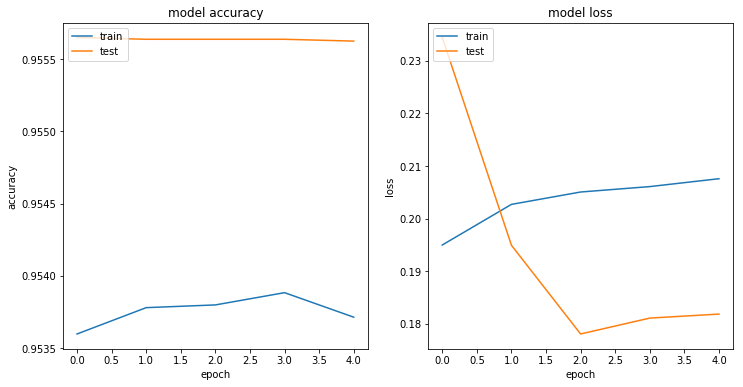

In [27]:
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('output/history_{}.png'.format(model_name))

In [28]:
prediction = model.predict_generator(validation_generator,
                                     steps=len(validation_generator),
                                     pickle_safe=True,
                                     verbose=1)
preds = np.zeros_like(prediction)
preds[np.arange(len(prediction)), prediction.argmax(1)] = 1

/opt/ds3/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `predict_generator` call to the Keras 2 API: `predict_generator(<keras.pre..., steps=284, verbose=1, use_multiprocessing=True)`
  after removing the cwd from sys.path.


284/284 [==============================] - 98s 345ms/step


In [66]:
validation_generator.classes.shape == preds.shape

True

In [102]:
y_true = validation_generator.classes
pred_cat = [labels[np.argmax(el)] for i,el in enumerate(preds)]

report = classification_report(y_true,preds)
np.save('output/report_{}.npy'.format(model_name),report)
print(report)
print('Accuracy score: ',accuracy_score(validation_generator.classes,preds))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       190
          1       0.00      0.00      0.00        13
          2       0.15      0.04      0.06       870
          3       0.00      0.00      0.00       276
          4       0.00      0.00      0.00        91
          5       0.09      0.96      0.16       511
          6       0.00      0.00      0.00       525
          7       0.00      0.00      0.00       170
          8       0.00      0.00      0.00       219
          9       0.00      0.00      0.00       191
         10       0.00      0.00      0.00       128
         11       0.00      0.00      0.00       209
         12       0.00      0.00      0.00        67
         13       0.00      0.00      0.00        67

avg / total       0.05      0.15      0.04      3527

Accuracy score:  0.033632681810177846


/opt/ds3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [86]:
score = model.evaluate_generator(validation_generator,
                                 steps=len(validation_generator),
                                 pickle_safe=True)
print('Accuracy Keras: ', score[1])

/opt/ds3/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras.pre..., steps=284, use_multiprocessing=True)`
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy Keras:  0.9556259985414267


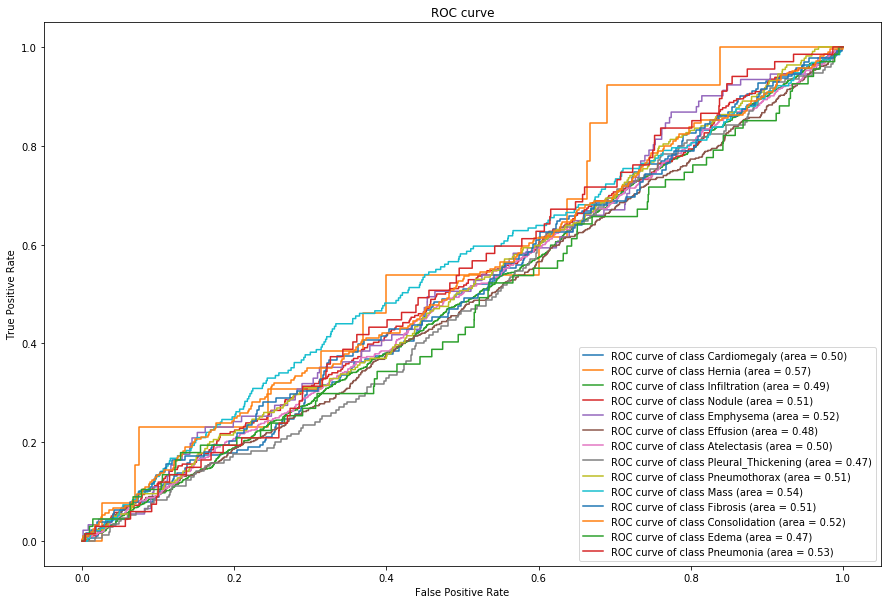

End Of Training


In [97]:
# Auc scores
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig = plt.figure(figsize=(15,10))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve for {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
fig.savefig('output/roc_curve_{}.png'.format(model_name))

print('End Of Training')

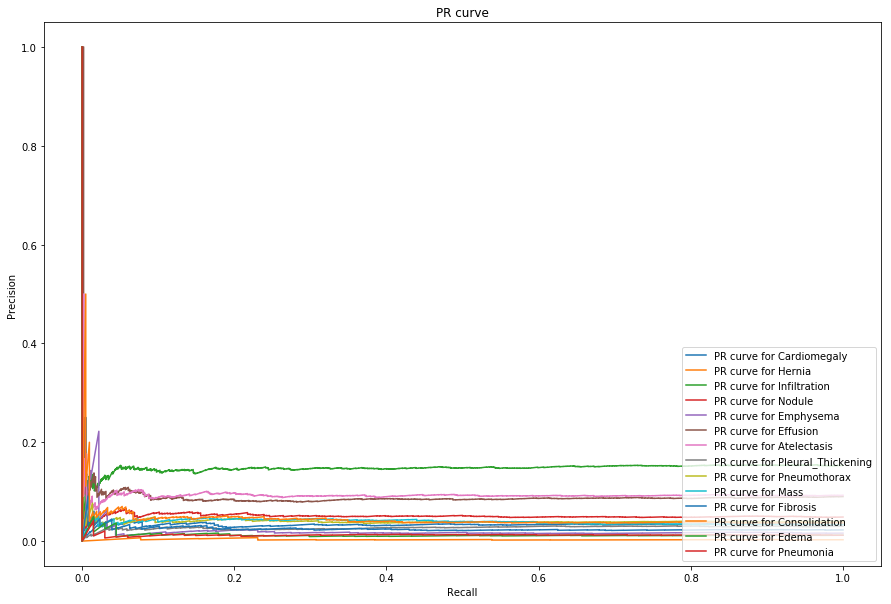

In [105]:
precision = dict()
recall = dict()
for i in range(len(labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], prediction[:, i])

fig = plt.figure(figsize=(15,10))
for i in range(len(labels)):
    plt.plot(recall[i], precision[i],
             label='PR curve for {0}'
             ''.format(labels[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc="lower right")
plt.show()